
#Graph methods for imaging, Vision and computing (B31RX) 2024

##Tutorial 5: Bayesian filtering with a discrete state space

In this tutorial, we will implement a Bayesian filter for online estimation of a (scalar) discrete state. We will first derive the data update step and then investigate the prediction step.



## Background

### Bayesian model:

We consider a simple state denoted $x_t ∈ \{0, ..., K-1\}$, which can take $K$ values at
each time instant. This state can vary over time with $t ∈ \{1, ..., T\}$


The variations of $x$ over time is modelled by a
homogeneous order-1 Markov chain such that the  probabilities

$$f(x_{t+1} = i | x_t = j) = π_{i,j}$$

are assumed to be known. Note that:
$Σ_{i=0}^{K-1} π_{i,j} = 1$.

This state is the parameter we try to estimate but it is not directly measured. Instead, we observe sequentially a set of observations $y_1, \ldots, y_T$ distributed to binomial distributions as follows:

$$
y_t | (x_t = i) \sim \text{Binomial}(N, \beta_i),
$$

where $N$ is a known integer and $\beta_0, \ldots, \beta_{K-1}$ are a set of known probabilities. More precisely, if $x_t = i$, the observation $y_t$ follows a binomial distribution whose probability of success depends on the value of the state $x_t$. The probability mass function of Binomial distribution with parameters $(N, \beta)$ is given by

$$
f(y|N, \beta) = \binom{N}{y} \beta^y (1 - \beta)^{N-y}.
$$

For simplicity, the parameter $N$ is shared across all models and does not depend on $x_t$. It should be noted that the data likelihood should be denoted by $f(y_t | (x_t = i, N, \beta_i))$. However, since $N$ and $\beta = \{\beta_0, \ldots, \beta_{K-1}\}$ are assumed to be known and fixed, they are omitted to simplify the notation.

### Question 1

Assuming that $N$ and $\beta = \{\beta_0, \ldots, \beta_{K-1}\}$ are known and that $x_t \in \{0, \ldots, K-1\}$, derive the expression of the MLE of $x_t$ (based on $y_t$).

$$\color{blue}{
\hat{x}_{\text{MLE},t} = \text{argmax}_{x_t \in \{0, \ldots, K-1\}} f(y_t | x_t)
}$$

$$\color{blue}{
\hat{x}_{\text{MLE},t} = \text{argmax}_{x_t \in \{0, \ldots, K-1\}} \log(f(y_t | x_t))
}$$

$$\color{blue}{
\hat{x}_{\text{MLE},t} = \text{argmax}_{x_t \in \{0, \ldots, K-1\}} [y_t \log(\beta_i) + (N - y_t) \log(1 - \beta_i)]
}$$

### Question 2

Open the file $\texttt{data_tutorial5_K=3_N=10.mat}$ and visualise the data in the variable $y$. It corresponds to $T = 1000$ observations associated with a state $x$ taking $K = 3$ values. The corresponding variables $N$ and $\beta$ are also provided in the file. For each time instant, compute the MLE of $x_t$, and compare the estimate sequence to the ground truth state also provided in the file. What do you observe?

In [ ]:
!git clone https://github.com/BISC-Group-HWU/B31XR.git
%cd B31XR/Tutorial\ 5

Cloning into 'B31XR'...
remote: Enumerating objects: 143, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 143 (delta 64), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (143/143), 7.57 MiB | 14.41 MiB/s, done.
Resolving deltas: 100% (64/64), done.
/content/B31XR/Tutorial 2/B31XR/Tutorial 5/B31XR/Tutorial 5/B31XR/Tutorial 5


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# Define the parameters and load the data
data = loadmat('data_tutorial5_K=3_N=10.mat')

# The data variable is a dictionary. We'll need to know the key names to access `T` and `N`
# Let's print out the keys
print(data.keys())

T = data['T'][0,0]
N = data['N'][0,0]
bet = data['bet'][0]
x = data['x'][0]
y = data['y'][0]


print(T)
print(N)
print(bet)
print(x.shape)
print(y.shape)

dict_keys(['__header__', '__version__', '__globals__', 'N', 'T', 'bet', 'x', 'y'])
1000
10
[0.05 0.5  0.95]
(1000,)
(1000,)


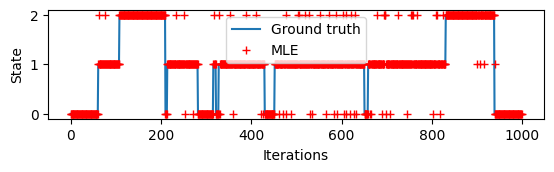

In [ ]:
# Main loop
log_likelihood = np.zeros((T, len(bet)))
x_MLE = np.zeros(T)
for t in range(T):

    log_likelihood[t, :] = y[t] * np.log(bet) + (N - y[t]) * np.log(1 - bet)

    # Compute MLE
    x_MLE[t] = np.argmax(log_likelihood[t, :])


# Plotting
plt.figure()
plt.subplot(311)
plt.plot(x, label='Ground truth')
plt.plot(x_MLE, 'r+', label='MLE')
plt.xlabel('Iterations')
plt.ylabel('State')
plt.legend()

$\color{blue}{\text{The MLE is generally good but the state is sometimes incorrectly estimated because of the observation noise.}}$

### Question 3

Before introducing the Bayesian filter, let's assume that a fixed prior distribution is assigned to $x_t$, i.e., we assume $f(x_t = i) = \alpha_i$, with $\{\alpha_i\}$ being known and $\sum_{i=0}^{K-1} \alpha_i = 1$.

Derive the expression of the MAP estimator of $x_t$ (based on $y_t$ and $(\alpha_0, \ldots, \alpha_{K-1})$).




$$\color{blue}{
\hat{x}_{\text{MAP},t} = \text{argmax}_{x_t \in \{0, \ldots, K-1\}} f(x_t | y_t)
}$$

$$\color{blue}{
\hat{x}_{\text{MAP},t} = \text{argmax}_{x_t \in \{0, \ldots, K-1\}} \log(f(x_t | y_t))
}$$

$$\color{blue}{
\hat{x}_{\text{MAP},t} = \text{argmax}_{x_t \in \{0, \ldots, K-1\}} [y_t \log(\beta_i) + (N - y_t) \log(1 - \beta_i) + \log(\alpha_i)]
}$$


### Question 4

Using the prior distribution defined by $f(x_t = i) = \alpha_i$, compute the posterior distribution of $x_t$, i.e., $f(x_t | y_t, \alpha_0, \ldots, \alpha_{K-1})$.

$\color{blue}{\text{
Using the Bayes' rule, we have
}}$

$$\color{blue}{
f(x_t = i | y_t, \alpha_0, \ldots, \alpha_{K-1}) \propto f(y_t | x_t = i) f(x_t = i).
}$$

$\color{blue}{\text{
Since $x_t$ can only take a finite number of values and $\sum_{j=0}^{K-1} f(x_t = j | y_t, \alpha_0, \ldots, \alpha_{K-1}) = 1$, the normalised posterior probabilities reduce to
}}$

$$\color{blue}{
f(x_t = i | y_t, \alpha_0, \ldots, \alpha_{K-1}) = \frac{f(y_t | x_t = i) f(x_t = i)}{\sum_{j=0}^{K-1} f(y_t | x_t = j) f(x_t = j)}
}$$

### Question 5

Using the Bayesian filter, we will not use a fixed prior $f(x_t)$ as in Question 3 and Question 4, but the distribution $f(x_{t-1} | \mathbf{y}_{t-1})$ where $\mathbf{y}_{t-1} = \{y_1, \ldots, y_{t-1}\}$.

For simplicity, let's introduce $\gamma_i = f(x_{t-1} = i|\mathbf{y}_{t-1})$. This probability is obtained after the data update at iteration $(t - 1)$. By marginalising $f(x_t, x_{t-1} | \mathbf{y}_{t-1})$, compute the adaptive prior distribution $f(x_t=i | \mathbf{y}_{t-1})$.

$$\color{blue}{
\begin{align*}
f(x_t = i | \mathbf{y}_{t-1}) &= \sum_{j=0}^{K-1} f(x_t = i, x_{t-1} = j | \mathbf{y}_{t-1}) \\
&= \sum_{j=0}^{K-1} f(x_t = i | x_{t-1} = j) f(x_{t-1} = j | \mathbf{y}_{t-1}) \\
&= \sum_{j=0}^{K-1} \pi_{ij} \gamma_j
\end{align*}
}$$

### Question 6

Question 6

Show that the computation of the predictive distribution $f(x_t = i | \mathbf{y}_{t-1})$ (for all $i$) can be computed using the multiplication of a $K \times K$ matrix by a $K \times 1$ vector.


$$\color{blue}{
\begin{bmatrix}
f(x_t = 0 | \mathbf{y}_{t-1}) \\
\vdots \\
f(x_t = K-1 | \mathbf{y}_{t-1})
\end{bmatrix}
=
\begin{bmatrix}
\pi_{0,0} & \cdots & \pi_{0,K-1} \\
\vdots & \ddots & \vdots \\
\pi_{K-1,0} & \cdots & \pi_{K-1,K-1}
\end{bmatrix}
\begin{bmatrix}
f(x_{t-1} = 0 | \mathbf{y}_{t-1}) \\
\vdots \\
f(x_{t-1} = K-1 | \mathbf{y}_{t-1})
\end{bmatrix}
}$$



$$\color{blue}{
\begin{bmatrix}
f(x_t = 0 | \mathbf{y}_{t-1}) \\
\vdots \\
f(x_t = K-1 | \mathbf{y}_{t-1})
\end{bmatrix}
=
\mathbf{P}
\begin{bmatrix}
\gamma_0 \\
\vdots \\
\gamma_{K-1}
\end{bmatrix}
}$$

$\color{blue}{\text{
With $\mathbf{P}$ defined as:
}}$

$$\color{blue}{
\mathbf{P} =
\begin{bmatrix}
\pi_{0,0} & \cdots & \pi_{0,K-1} \\
\vdots & \ddots & \vdots \\
\pi_{K-1,0} & \cdots & \pi_{K-1,K-1}
\end{bmatrix}
}$$


### Question 7

Use the data in the file $\texttt{data_tutorial5_K=3_N=10.mat}$ to implement your Bayesian filter.

Initialise the prior for the initial state as follows (with strongly believe the initial state is 0 or 1):

$$
\begin{cases}
f(x_1 = 0) = 0.9 \\
f(x_1 = 1) = 0.1 \\
f(x_1 > 1) = 0
\end{cases}
$$

Set the transition probabilities as follows

$$
\mathbf{P} = \begin{bmatrix}
0.99 & 0.005 & 0.01 \\
0.01 & 0.99 & 0 \\
0 & 0.005 & 0.99
\end{bmatrix}
$$

Compare the estimates obtained via Bayesian filter to those obtained via MLE.

<ipython-input-31-67045ac7af76>:21: RuntimeWarning: divide by zero encountered in log
  log_posterior = log_likelihood[t, :] + np.log(prior)


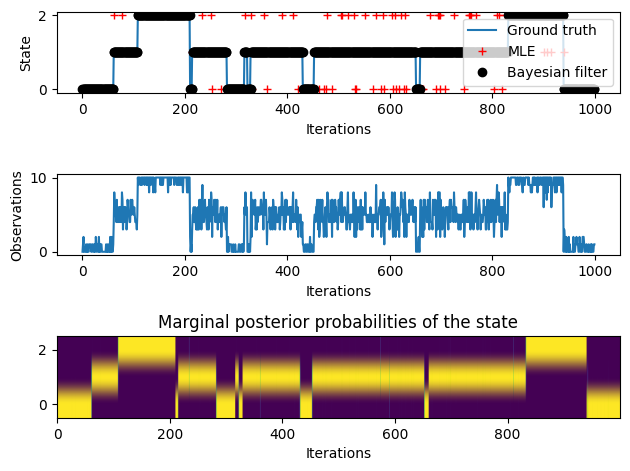

In [ ]:
prior = np.array([0.9, 0.1, 0])  # We know we start in state 0
Pt = np.array([[0.99, 0.01, 0],
               [0.005, 0.99, 0.005],
               [0.01, 0, 0.99]]).T

# Assuming T and N are defined in the loaded data
x_MLE = np.zeros(T)
x_MAP = np.zeros(T)
log_likelihood = np.zeros((T, len(bet)))
posterior = np.zeros((len(bet), T))

# Main loop
for t in range(T):

    log_likelihood[t, :] = y[t] * np.log(bet) + (N - y[t]) * np.log(1 - bet)

    # Compute MLE
    x_MLE[t] = np.argmax(log_likelihood[t, :])

    # Data update (KF)
    log_posterior = log_likelihood[t, :] + np.log(prior)
    b = log_posterior - np.max(log_posterior)
    b = np.exp(b)
    posterior[:, t] = b / np.sum(b)

    # Prediction step (for time t+1)
    prior = Pt @ posterior[:, t]
    x_MAP[t] = np.argmax(b)

# Plotting
plt.figure()
plt.subplot(311)
plt.plot(x, label='Ground truth')
plt.plot(x_MLE, 'r+', label='MLE')
plt.plot(x_MAP, 'ko', label='Bayesian filter')
plt.xlabel('Iterations')
plt.ylabel('State')
plt.legend()

plt.subplot(312)
plt.plot(y)
plt.xlabel('Iterations')
plt.ylabel('Observations')

plt.subplot(313)
plt.imshow(posterior, aspect='auto', origin='lower')
plt.xlabel('Iterations')
plt.title('Marginal posterior probabilities of the state')

plt.tight_layout()
plt.show()

$\color{blue}{\text{
The MLE is affected by the observation noise, while the Bayesian filter (with sequential MAP estimation) remains robust.
}}$

### Question 8

Using the same filter, estimate the state sequence in the file $\texttt{data_tutorial5_K=3_N=5.mat}$. This data corresponds to more noisy observations obtained with $N = 5$. What do you observe?




dict_keys(['__header__', '__version__', '__globals__', 'N', 'T', 'bet', 'x', 'y'])


<ipython-input-32-c246cf9b5c93>:34: RuntimeWarning: divide by zero encountered in log
  log_posterior = log_likelihood[t, :] + np.log(prior)


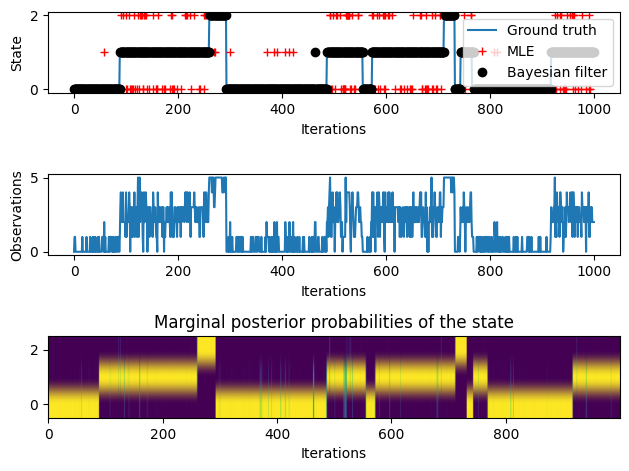

In [ ]:
# Define the parameters and load the data
data = loadmat('data_tutorial5_K=3_N=5.mat')

# The data variable is a dictionary. We'll need to know the key names to access `T` and `N`
# Let's print out the keys
print(data.keys())

T = data['T'][0,0]
N = data['N'][0,0]
bet = data['bet'][0]
x = data['x'][0]
y = data['y'][0]

prior = np.array([0.9, 0.1, 0])  # We know we start in state 0
Pt = np.array([[0.99, 0.01, 0],
               [0.005, 0.99, 0.005],
               [0.01, 0, 0.99]]).T

# Assuming T and N are defined in the loaded data
x_MLE = np.zeros(T)
x_MAP = np.zeros(T)
log_likelihood = np.zeros((T, len(bet)))
posterior = np.zeros((len(bet), T))

# Main loop
for t in range(T):

    log_likelihood[t, :] = y[t] * np.log(bet) + (N - y[t]) * np.log(1 - bet)

    # Compute MLE
    x_MLE[t] = np.argmax(log_likelihood[t, :])

    # Data update (KF)
    log_posterior = log_likelihood[t, :] + np.log(prior)
    b = log_posterior - np.max(log_posterior)
    b = np.exp(b)
    posterior[:, t] = b / np.sum(b)

    # Prediction step (for time t+1)
    prior = Pt @ posterior[:, t]
    x_MAP[t] = np.argmax(b)

# Plotting
plt.figure()
plt.subplot(311)
plt.plot(x, label='Ground truth')
plt.plot(x_MLE, 'r+', label='MLE')
plt.plot(x_MAP, 'ko', label='Bayesian filter')
plt.xlabel('Iterations')
plt.ylabel('State')
plt.legend()

plt.subplot(312)
plt.plot(y)
plt.xlabel('Iterations')
plt.ylabel('Observations')

plt.subplot(313)
plt.imshow(posterior, aspect='auto', origin='lower')
plt.xlabel('Iterations')
plt.title('Marginal posterior probabilities of the state')

plt.tight_layout()
plt.show()

$\color{blue}{\text{
The MLE is more affected by the observation noise (which increases), while the Bayesian filter (with sequential MAP estimation) remains robust.
}}$

### Question 9 (Extra question)

Modify your Bayesian filter assuming $K = 4$. Keep
$$
\begin{cases}
f(x_1 = 0) = 0.9 \\
f(x_1 = 1) = 0.1 \\
f(x_1 > 1) = 0
\end{cases}
$$
To define the initial prior distribution and use
$$
\mathbf{P} = \begin{bmatrix}
0.99 & 0.005 & 0 & 0.05 \\
0.01 & 0.99 & 0 & 0 \\
0 & 0.005 & 0.99 & 0 \\
0 & 0 & 0.01 & 0.95
\end{bmatrix}.
$$

Using the new filter, estimate the state sequences in the files

$$\texttt{data_tutorial5_K=4_N=5.mat}$$

$$\texttt{data_tutorial5_K=4_N=10.mat}$$

What do you observe?

dict_keys(['__header__', '__version__', '__globals__', 'N', 'T', 'bet', 'x', 'y'])


<ipython-input-33-7a844d2f9e3c>:35: RuntimeWarning: divide by zero encountered in log
  log_posterior = log_likelihood[t, :] + np.log(prior)


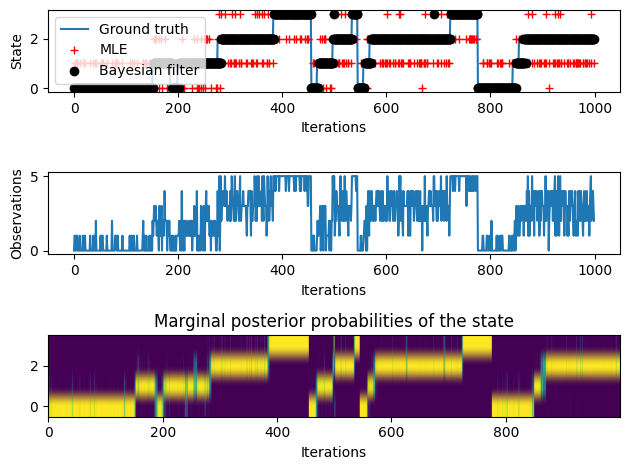

In [ ]:
# Define the parameters and load the data
data = loadmat('data_tutorial5_K=4_N=5.mat')

# The data variable is a dictionary. We'll need to know the key names to access `T` and `N`
# Let's print out the keys
print(data.keys())

T = data['T'][0,0]
N = data['N'][0,0]
bet = data['bet'][0]
x = data['x'][0]
y = data['y'][0]

prior = np.array([0.9, 0.1, 0, 0])  # We know we start in state 0
Pt = np.array([[0.99, 0.01, 0, 0],
               [0.005, 0.99, 0.005, 0],
               [0, 0, 0.99, 0.01],
               [0.05, 0, 0, 0.95]]).T

# Assuming T and N are defined in the loaded data
x_MLE = np.zeros(T)
x_MAP = np.zeros(T)
log_likelihood = np.zeros((T, len(bet)))
posterior = np.zeros((len(bet), T))

# Main loop
for t in range(T):

    log_likelihood[t, :] = y[t] * np.log(bet) + (N - y[t]) * np.log(1 - bet)

    # Compute MLE
    x_MLE[t] = np.argmax(log_likelihood[t, :])

    # Data update (KF)
    log_posterior = log_likelihood[t, :] + np.log(prior)
    b = log_posterior - np.max(log_posterior)
    b = np.exp(b)
    posterior[:, t] = b / np.sum(b)

    # Prediction step (for time t+1)
    prior = Pt @ posterior[:, t]
    x_MAP[t] = np.argmax(b)

# Plotting
plt.figure()
plt.subplot(311)
plt.plot(x, label='Ground truth')
plt.plot(x_MLE, 'r+', label='MLE')
plt.plot(x_MAP, 'ko', label='Bayesian filter')
plt.xlabel('Iterations')
plt.ylabel('State')
plt.legend()

plt.subplot(312)
plt.plot(y)
plt.xlabel('Iterations')
plt.ylabel('Observations')

plt.subplot(313)
plt.imshow(posterior, aspect='auto', origin='lower')
plt.xlabel('Iterations')
plt.title('Marginal posterior probabilities of the state')

plt.tight_layout()
plt.show()

$\color{blue}{\text{
The Bayesian filter is more robust than the MLE-based method as 1) the quality of the observations degrades and 2) as the similarity between the states increases (closer probabilities in the vector $\beta$)
}}$